In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats as ss
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import pickle
import os
import scipy
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
plt.rc('text', usetex = True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,xcolor,siunitx}')

SMALLER_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE, title_fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

%matplotlib inline

# Real data

In [2]:
s2 = pd.read_excel('../data/41431_2019_511_MOESM2_ESM.xlsx', sheet_name=None)

h2 = s2['allresults_2019-05-12'].query(
    '''
    gene_biotype=="protein_coding" & \
    zerocounts_in_MZ <= (918-780) & \
    zerocounts_in_DZ <= (300-255) & \
    raw_median_count_per_gene > 10 & \
    N_SNPS > 20
    '''
).copy()

# add some stuff to Ouwens' df
h2['GCTA_Frac'] = h2['GCTA_VG2ofVp'] / h2['GCTA_Sum']
h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$']] = h2[['cis_eqtl_beta', 'trans_eqtl_beta']] ** 2
h2[r'$h^2_{cis}/h^2$'] = [f if not np.isnan(beta) else np.nan for _,(f,beta) in h2[['GCTA_Frac','cis_eqtl_beta']].iterrows()]

display(h2.shape, h2.columns, h2.head())

display(h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$', 'GCTA_Frac', r'$h^2_{cis}/h^2$']].describe())

ouwens_h2_cis = h2[r'$h^2_{cis}/h^2$'].dropna().values

(11409, 52)

Index(['GENE', 'raw_mean_count_per_gene', 'raw_median_count_per_gene',
       'residualized_mean_count_per_gene',
       'residualized_median_count_per_gene', 'zerocounts_in_DZ',
       'zerocounts_in_MZ', 'zerocounts_in_all', 'falconer_h2', 'MZcorrelation',
       'DZcorrelation', 'ACE_A', 'ACE_C', 'ACE_E', 'ACE_AICc', 'AE_A', 'AE_E',
       'AE_AICc', 'ACE_CE_Pvalue', 'GCTA_VG1ofVp', 'GCTA_VG1ofVP_SE',
       'GCTA_VG2ofVp', 'GCTA_VG2ofVp_SE', 'GCTA_Sum', 'GCTA_Sum_SE', 'N_SNPS',
       'hgnc_symbol', 'chromosome_name', 'start_position', 'end_position',
       'ensembl_transcript_id', 'gene_biotype', 'cis_eqtl_chromosome',
       'cis_eqtl_SNP', 'cis_eqtl_bp', 'cis_eqtl_effect_allele',
       'cis_eqtl_non_affect_allele', 'cis_eqtl_beta', 'cis_eqtl_P',
       'cis_eqtl_FDR', 'trans_eqtl_chromosome', 'trans_eqtl_SNP',
       'trans_eqtl_bp', 'trans_eqtl_effect_allele',
       'trans_eqtl_non_affect_allele', 'trans_eqtl_beta', 'trans_eqtl_P',
       'trans_eqtl_FDR', 'GCTA_Frac', '$\be

,GENE,raw_mean_count_per_gene,raw_median_count_per_gene,residualized_mean_count_per_gene,residualized_median_count_per_gene,zerocounts_in_DZ,zerocounts_in_MZ,zerocounts_in_all,falconer_h2,MZcorrelation,...,trans_eqtl_bp,trans_eqtl_effect_allele,trans_eqtl_non_affect_allele,trans_eqtl_beta,trans_eqtl_P,trans_eqtl_FDR,GCTA_Frac,$\beta^2_{cis}$,$\beta^2_{trans}$,$h^2_{cis}/h^2$
0,ENSG00000000419,133.743537,130.906235,1.180238e-18,-0.008395,0,0,0,-0.197863,0.106157,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011544,NaN,NaN,NaN
1,ENSG00000000457,124.870722,123.678165,2.059187e-18,-0.008612,0,0,0,0.165453,0.092706,...,169751853.0,T,C,-0.215534,2.440030e-08,4.036602e-07,0.717255,0.076627,0.046455,0.717255
2,ENSG00000000460,57.516552,56.681662,3.698310e-18,-0.012563,0,0,0,0.357618,0.335635,...,169580717.0,C,T,-0.272360,3.471390e-10,7.216771e-09,0.878784,0.380575,0.074180,0.878784
3,ENSG00000000938,13099.475192,12631.371927,-1.336965e-18,0.015804,0,0,0,0.397230,0.368861,...,NaN,NaN,NaN,NaN,NaN,NaN,0.043470,NaN,NaN,NaN
4,ENSG00000000971,20.054503,16.879363,3.629941e-18,-0.009700,3,6,12,0.561934,0.485259,...,NaN,NaN,NaN,NaN,NaN,NaN,0.010867,NaN,NaN,NaN


,$\beta^2_{cis}$,$\beta^2_{trans}$,GCTA_Frac,$h^2_{cis}/h^2$
count,5902.000000,5902.000000,11353.000000,5886.000000
mean,0.265897,0.132362,0.204536,0.335554
std,0.366534,0.203661,0.232011,0.225782
min,0.026803,0.024794,0.000001,0.000003
25%,0.073347,0.046914,0.028383,0.153760
50%,0.142890,0.072513,0.114606,0.280070
75%,0.324170,0.133108,0.306585,0.474463
max,7.492373,5.847836,0.999996,0.999996


# Synthetic data

In [3]:
sf_file = 'figdata/dsfg.graphs.parquet2'
sf_stub = os.path.join(
    os.path.dirname(sf_file),
    'graphs',
    os.path.splitext(os.path.basename(sf_file))[0]
)

ppm_file = 'figdata/ppm.graphs.parquet2'
ppm_stub = os.path.join(
    os.path.dirname(ppm_file),
    'graphs',
    os.path.splitext(os.path.basename(ppm_file))[0]
)

sf_grns = pd.read_parquet(sf_file)
ppm_grns = pd.read_parquet(ppm_file)

## Best-matched GRN

In [4]:
sf_grns['y'] = sf_grns['Median ' + r'$V_{cis}/V_{tot}$']
ppm_grns['y'] = ppm_grns['Median ' + r'$V_{cis}/V_{tot}$']


columns = ['model','n','r','k','m','d','gamma','p_up','y']
sf_grns.loc[[8545], columns]

,model,n,r,k,m,d,gamma,p_up,y
8545,dsfg,5000,7.933735,79,0.97751,4.119013,0.293456,0.926322,0.277896


## Match to previous, with more uniform out-degree 

Keep $h^2_{\text{cis}} / h^2$ close, ideally keep $r$ similar with some tolerance, and have $d$ at the large end of its range.

In [5]:
query = '7.5 < r & r < 8.5 & d > 20 & 0.27 < y & y < 0.285'

sf_grns.query(query).head(1)[columns]

,model,n,r,k,m,d,gamma,p_up,y
2578,dsfg,5000,7.934845,40,0.907661,24.356679,0.400096,0.155403,0.278358


## Match to previous, with non-modular PPM architecture

Keep $h^2_{\text{cis}} / h^2$ close, ideally keep $r$ similar with some tolerance, and have $m$ at the small end of its range.

In [6]:
ppm_grns.columns

Index(['model', 'n', 'r', 'k', 'gamma', 'p_up', 'hier', 'w', 'm',
       '$V_{cis}/V_{tot}$', '$max(B_{trans}^2/V_{cis})$', 'triangles',
       'diamonds', 'Median $V_{cis}/V_{tot}$', 'in_degrees', 'out_degrees',
       'in_group_edges', 'y'],
      dtype='object')

In [7]:
query = '7.5 < r & r < 8.5 & m < 0.1 & 0.27 < y & y < 0.285'

ppm_grns.query(query).head(1)[[i for i in columns if i != 'd']]

,model,n,r,k,m,gamma,p_up,y
138,ppm,5000,8.043429,53,0.03801,0.405085,0.153104,0.275178


# Load synthetic networks

Decompose variance as a function of distance, and compute "eQTL" effects.

In [8]:
ix1, ix2 = 8545, 2578
ix3 = 138
display(pd.concat([sf_grns.iloc[[ix1, ix2],:], ppm_grns.iloc[[ix3],:]])[columns])

with open('.'.join((sf_stub, str(ix1), 'pkl')), 'rb') as g:
    G1 = pickle.load(g) 
if 'V_dist' not in dir(G1):
    G1.decompose_variance()
    with open('.'.join((sf_stub, str(ix1), 'pkl')), 'wb') as g:
        pickle.dump(G1, g)
        
        

with open('.'.join((sf_stub, str(ix2), 'pkl')), 'rb') as g:
    G2 = pickle.load(g) 
if 'V_dist' not in dir(G2):
    G2.decompose_variance()
    with open('.'.join((sf_stub, str(ix2), 'pkl')), 'wb') as g:
        pickle.dump(G2, g)

with open('.'.join((ppm_stub, str(ix3), 'pkl')), 'rb') as g:
    G3 = pickle.load(g) 
if 'V_dist' not in dir(G3):
    G3.decompose_variance()
    with open('.'.join((ppm_stub, str(ix3), 'pkl')), 'wb') as g:
        pickle.dump(G3, g)
        
B1 = (G1.L ** 2 - np.eye(G1.n)) / np.diag(G1.L.T.dot(G1.L))
B2 = (G2.L ** 2 - np.eye(G2.n)) / np.diag(G2.L.T.dot(G2.L))
B3 = (G3.L ** 2 - np.eye(G3.n)) / np.diag(G3.L.T.dot(G3.L))

,model,n,r,k,m,d,gamma,p_up,y
8545,dsfg,5000,7.933735,79,0.977510,4.119013,0.293456,0.926322,0.277896
2578,dsfg,5000,7.934845,40,0.907661,24.356679,0.400096,0.155403,0.278358
138,ppm,5000,8.043429,53,0.038010,NaN,0.405085,0.153104,0.275178


In [9]:
print('outgoing trans eqtls')
n_tns = pd.concat(
    {label: pd.Series((B > 1e-10).sum(axis=1)) for label,B in zip(
        ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'],
        [B1, B2, B3]
    )}, axis=1
)
print(n_tns.quantile([.20, .50, .75, .90, .95, .99, .995]))

print('incoming trans eqtls')
n_tns = pd.concat(
    {label: pd.Series((B > 1e-10).sum(axis=0)) for label,B in zip(
        ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'],
        [B1, B2, B3]
    )}, axis=1
)
print(n_tns.quantile([.20, .50, .75, .90, .95, .99, .995]))

outgoing trans eqtls
       SF GRN (small d)  SF GRN (large d)  PPM GRN (small m)
0.200             0.000             1.000             13.000
0.500             4.000            26.000            679.500
0.750            23.000           292.000           1800.000
0.900            65.000          1777.300           2591.000
0.950           127.000          2936.000           2913.100
0.990          1705.090          4535.010           3286.010
0.995          3884.085          4843.005           3387.105
incoming trans eqtls
       SF GRN (small d)  SF GRN (large d)  PPM GRN (small m)
0.200              36.8           146.800             13.000
0.500              61.0           413.500            589.500
0.750              84.0           696.500           1844.250
0.900             108.0           930.100           2667.000
0.950             122.0          1051.100           2982.100
0.990             159.0          1305.020           3279.040
0.995             167.0          1366.035  

# Figure 6

SF GRN (small d) [0.27789633 0.67149884 0.91196516 0.99712518 0.99995144]
SF GRN (large d) [0.2783577  0.57283824 0.84275352 0.95480802 0.99191565]
PPM GRN (small m) [0.27517813 0.63434266 0.86645935 0.96415652 0.99336417]
       SF GRN (small d)  SF GRN (large d)  PPM GRN (small m)
count        5000.00000       5000.000000        5000.000000
mean           64.00960        464.807800         998.731800
std            33.12778        327.038736        1046.661312
min             0.00000          0.000000           0.000000
25%            41.00000        184.000000          33.000000
50%            61.00000        413.500000         589.500000
75%            84.00000        696.500000        1844.250000
max           217.00000       1554.000000        3726.000000
       SF GRN (small d)  SF GRN (large d)  PPM GRN (small m)
count      5.000000e+03      5.000000e+03       5.000000e+03
mean       1.827067e-01      9.055899e-02       5.432009e-02
std        8.684146e-02      3.343273e-02    

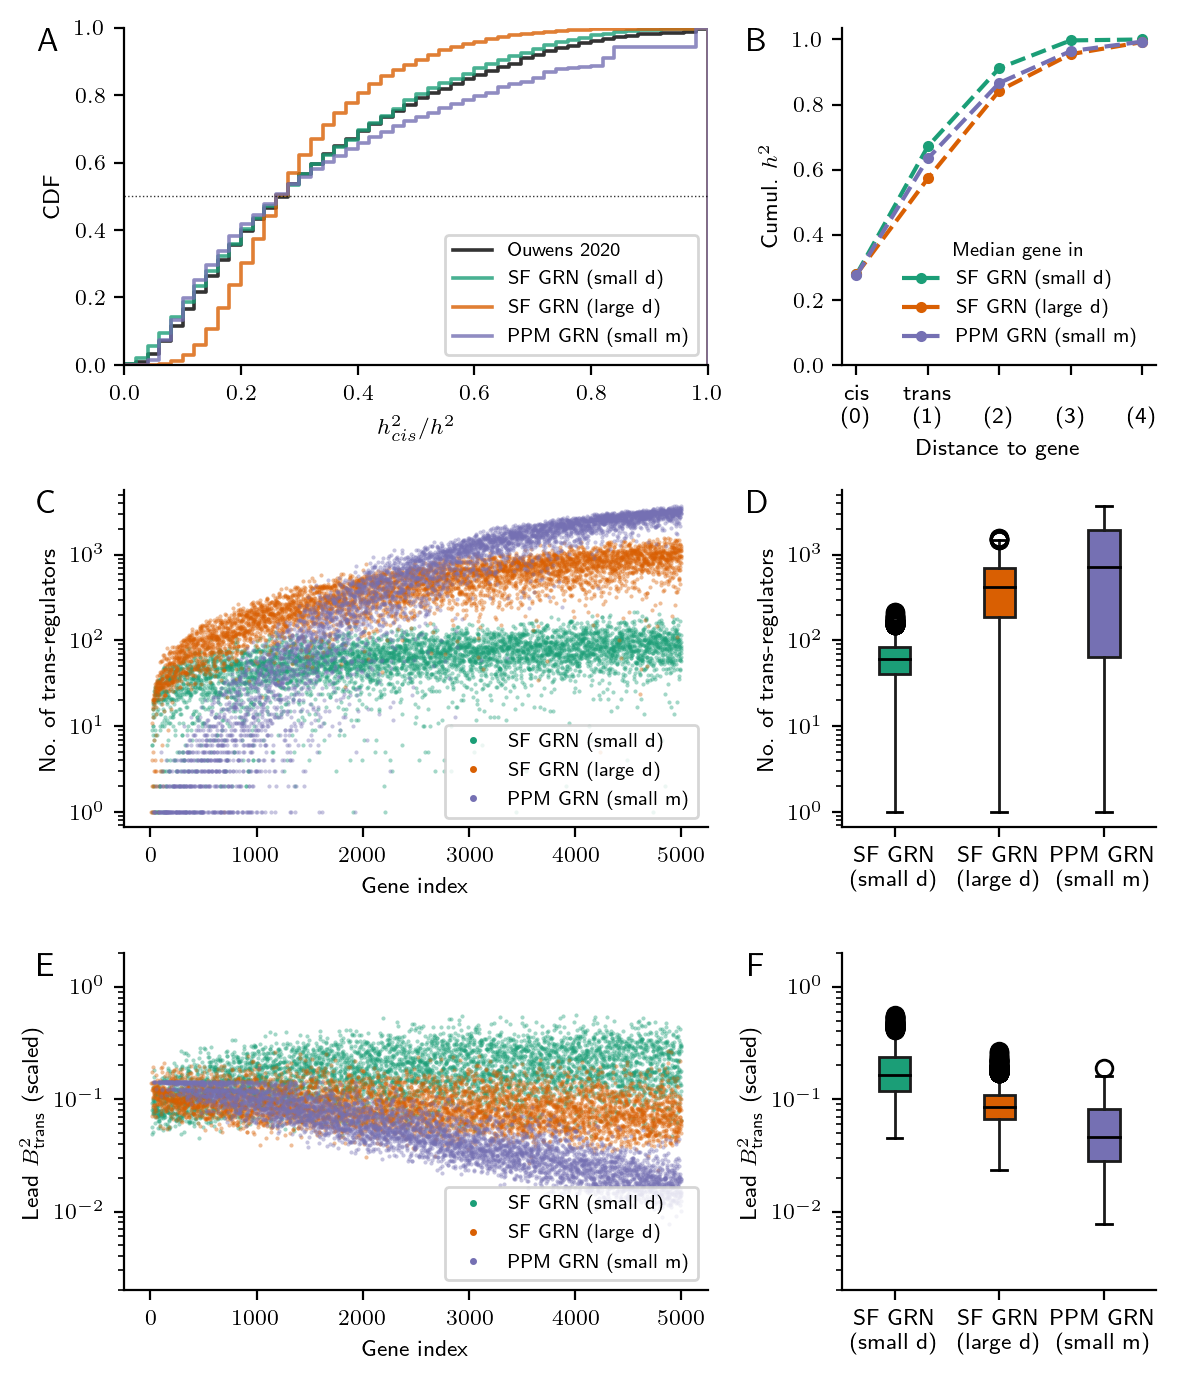

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(6, 7), dpi=200, width_ratios=(0.65, 0.35))


# AB: H2CIS CDF
ax = axs[0,0]

x_bins = np.linspace(0, 1, 51)

# ouwens
x = np.cumsum(np.histogram(h2.loc[h2['cis_eqtl_SNP'].notnull(), 'GCTA_Frac'], bins = x_bins)[0])


ax.step(
    x_bins, 
    np.hstack([x, 0])/h2['cis_eqtl_SNP'].notnull().sum(), 
    where='post', 
    color='k', 
    linewidth=1.3, 
    alpha=0.8,
    label='Ouwens 2020'
)

# networks
for row, label in zip([sf_grns.loc[ix1,:], sf_grns.loc[ix2,:], ppm_grns.loc[ix3,:]],
                      ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)']):

    x = np.cumsum(np.histogram(row['$V_{cis}/V_{tot}$'], bins = x_bins)[0])
    
    # plot
    ax.step(
        x_bins, 
        np.hstack([x, 0])/row.n, 
        where='post', 
        linewidth=1.3, 
        alpha=0.8,
        label=label
    )

ax.set_xlim(0,1); 
ax.set_xlabel(r'$h^2_{cis} / h^2$');
ax.set_ylim(0,1);
ax.set_ylabel('CDF');
ax.legend(frameon=1, loc='lower right');
ax.axhline(
    0.5, 
    color='k',
    linestyle=':',
    linewidth=0.5,
    alpha = 0.8
);


ax = axs[0,1]
for i,(G,label) in enumerate(zip([G1,G2,G3],['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):
    print(label, np.median(G.V_dist[:,:5], axis=0))
    ax.plot(range(5), 
            np.median(G.V_dist[:,:5], axis=0), 
             '.--',
             #where='post',
             label=label
    );
ax.set_xticks(range(5), labels=['cis\n(0)', 'trans\n(1)', '\n(2)', '\n(3)', '\n(4)']);
ax.set_xlabel('Distance to gene');
ax.set_yticks(np.linspace(0, 1, 6));
ax.set_ylabel('Cumul. '+r'$h^2$');
ax.legend(title='Median gene in', frameon=False, loc = 'lower right');



# CD: Number of trans eQTLs per gene
ax = axs[1,0]

n_tns = pd.concat(
    {label: pd.Series((B > 1e-10).sum(axis=0)) for label,B in zip(
        ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'],
        [B1, B2, B3]
    )}, axis=1
)
print(n_tns.describe())
n_tns[n_tns < 1] = np.nan

n_tns.plot(
    marker='.', 
    markersize=1, 
    linestyle='', 
    alpha=0.4,
    ax = ax
);
ax.set_yscale('log');
ax.set_ylabel('No. of trans-regulators');
#ax.set_ylim(0.3, 1e4);
legend = ax.legend(frameon=1, loc='lower right');
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    lh.set_markersize(3)
ax.set_xlabel('Gene index');



ax = axs[1,1]
boxes = n_tns.rename({c:c.replace('GRN','GRN\n') for c in n_tns.columns}, axis=1).boxplot(
    ax = ax,
    patch_artist = True,
    return_type = 'dict'
); 

for i,box in enumerate(boxes['boxes']):
    c = plt.get_cmap('Dark2')(i)
    box.set(facecolor = c)
    
for med in boxes['medians']:
    med.set(color='k')
ax.set_yscale('log');
ax.set_ylim(axs[1,0].get_ylim());
ax.set_ylabel(axs[1,0].get_ylabel());
ax.grid(False);


# EF: Lead trans eQTL effect sizes per gene
ax = axs[2,0]

b_tns = pd.concat(
    {label: pd.Series(np.max(B, axis=0)) for label,B in zip(
        ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'],
        [B1, B2, B3]
    )}, axis=1
)
print(b_tns.describe())
b_tns[b_tns < 1e-4] = np.nan

b_tns.plot(
    marker='.', 
    markersize=1, 
    linestyle='', 
    alpha=0.4,
    ax = ax
);
ax.set_yscale('log');
ax.set_ylabel('Lead {} (scaled)'.format(r'$B^2_{\text{trans}}$'));
ax.set_ylim(2e-3, 2e0);
legend = ax.legend(frameon=1, loc='lower right');
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    lh.set_markersize(3)
    
ax.set_xlabel('Gene index');


ax = axs[2,1]

boxes = b_tns.rename({c:c.replace('GRN','GRN\n') for c in b_tns.columns}, axis=1).boxplot(
    ax = ax,
    patch_artist = True,
    return_type='dict'
); 

for i,box in enumerate(boxes['boxes']):
    c = plt.get_cmap('Dark2')(i)
    box.set(facecolor = c)
    
for med in boxes['medians']:
    med.set(color='k')

ax.set_yscale('log');
ax.set_ylim(axs[2,0].get_ylim());
ax.set_ylabel(axs[2,0].get_ylabel());
ax.grid(False);


for i,(ax_ix, ax) in enumerate(np.ndenumerate(axs)):
    ax.text(
        -0.15 - 0.15*ax_ix[1],
        1.0,
        'ABCDEF'[i],
        fontsize=12,
        ha = 'left',
        va = 'top',
        transform = ax.transAxes
    );  
    

sns.despine();
fig.tight_layout();
fig.savefig('png/Figure6.png');

# Supplement

## Serape

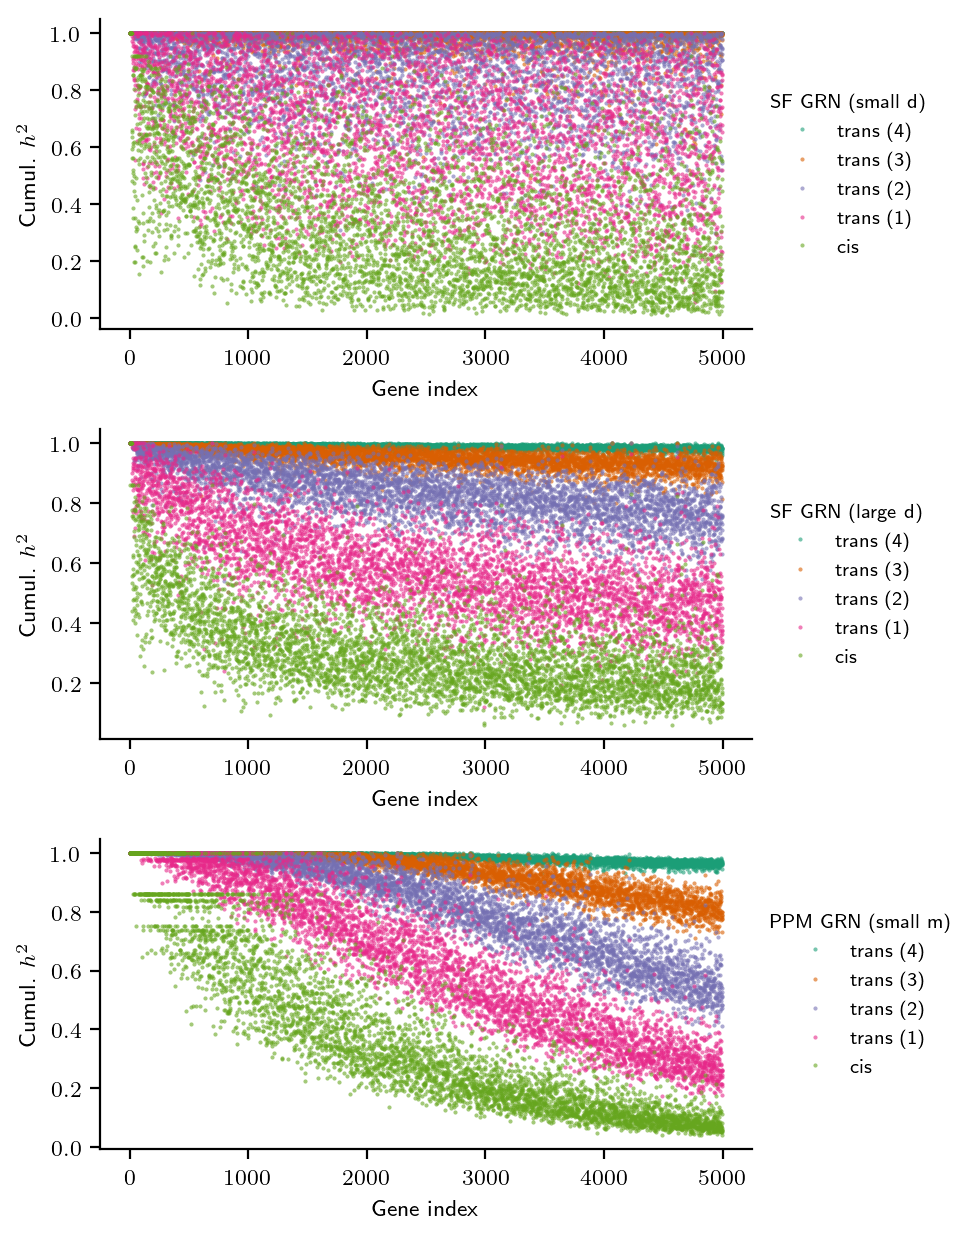

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6.3), dpi=200);

for i,(G,label) in enumerate(zip([G1,G2,G3], ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):

    axs[i].plot(G.V_dist[:,:5][:,::-1], '.', ms=1, alpha=0.6);

    axs[i].legend(
        ['cis', 'trans (1)', 'trans (2)', 'trans (3)', 'trans (4)'][::-1],
        title=label,
        frameon=False, 
        bbox_to_anchor=[1, 0.5], 
        loc='center left'
    )
    
    axs[i].set_xlabel('Gene index');
    axs[i].set_ylabel('Cumul. {}'.format(r'$h^2$'));

fig.tight_layout();
sns.despine();
fig.savefig('png/supplement/Fig_S6A.png');

## Median distance (with ranges)

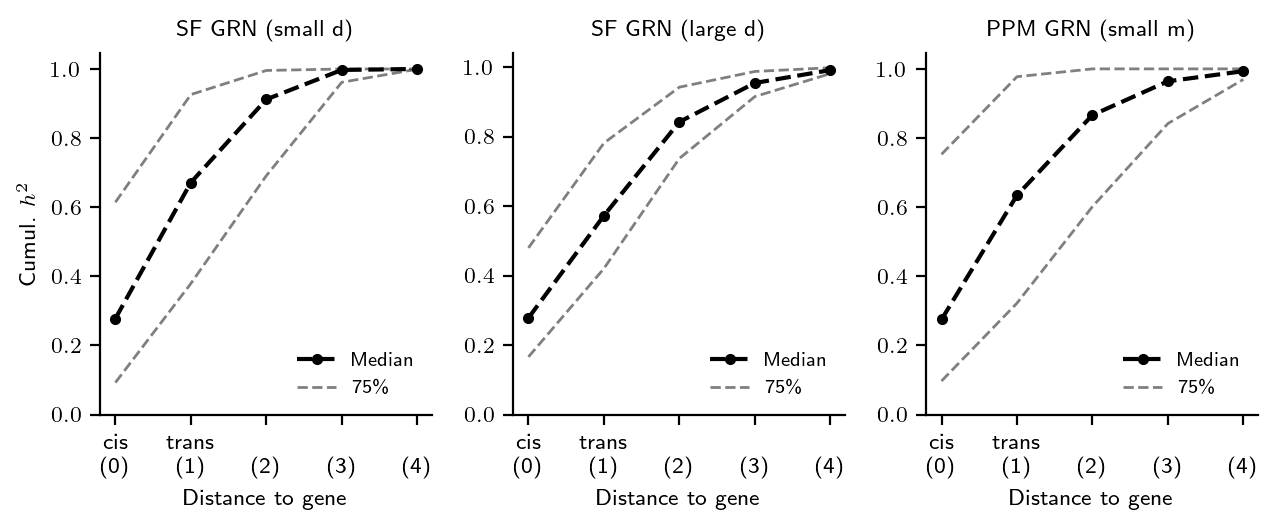

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.75), dpi=200)

for i,(G,label) in enumerate(zip([G1,G2,G3], ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):

    axs[i].plot(range(5), np.median(G.V_dist[:,:5], axis=0), 
             'k.--',
             #where='post',
             label='Median'
    );
    axs[i].plot(range(5), np.quantile(G.V_dist[:,:5], 0.125, axis=0), 
             'k--', 
             linewidth=1, 
             alpha=0.5, 
             #where='post',
             label='75\%'
    );
    axs[i].plot(range(5), np.quantile(G.V_dist[:,:5], 0.875, axis=0), 
             'k--', 
             linewidth=1, 
             alpha=0.5, 
             #where='post'
             label=None
    );

    axs[i].set_xticks(range(5), labels=['cis\n(0)', 'trans\n(1)', '\n(2)', '\n(3)', '\n(4)']);
    axs[i].set_xlabel('Distance to gene');
    axs[i].set_yticks(np.linspace(0, 1, 6));
    axs[0].set_ylabel('Cumul. '+r'$h^2$');
    axs[i].legend(frameon=False);
    axs[i].set_title(label);

sns.despine();
fig.tight_layout(h_pad=0.0);
fig.savefig('png/supplement/Fig_S6B.png');

## Relevant numbers

In [13]:
# number of incoming trans effects (nominal effect size)
np.median((B1 > 1e-10).sum(axis=0)), np.median((B2 > 1e-10).sum(axis=0)), np.median((B3 > 1e-10).sum(axis=0))

(61.0, 413.5, 589.5)

In [14]:
# number of incoming trans effects (detectable effect size)
q = 1e-2
np.median((B1 > q).sum(axis=0)), np.median((B2 > q).sum(axis=0)), np.median((B3 > q).sum(axis=0))

(15.0, 15.0, 11.0)

In [15]:
# number of outgoing trans-effects (for genes with several such effects)
np.median((B1[(B1 > 1e-10).sum(axis=1) > 10,:] > 1e-10).sum(axis=1)), np.median((B2[(B2 > 1e-10).sum(axis=1) > 10,:] > 1e-10).sum(axis=1)), np.median((B3[(B3 > 1e-10).sum(axis=1) > 10,:] > 1e-10).sum(axis=1))

(37.0, 168.0, 1101.0)

In [16]:
np.median((B1[(B1 > 1e-2).sum(axis=1) > 1,:] > 1e-2).sum(axis=1)), np.median((B2[(B2 > 1e-2).sum(axis=1) > 1,:] > 1e-2).sum(axis=1)), np.median((B3[(B3 > 1e-2).sum(axis=1) > 1,:] > 1e-2).sum(axis=1))

(5.0, 8.0, 9.0)

In [17]:
(B1 > 1e-10).sum(axis=1), (B2 > 1e-10).sum(axis=1), (B3 > 1e-10).sum(axis=1)

(array([4781, 4806, 4678, ...,    0,    0,    0]),
 array([4967, 4963, 4956, ...,    0,    0,    0]),
 array([3328, 3000, 3332, ...,    0,    0,    0]))

In [18]:
np.median(np.max(B1 ** 2, axis=0)), np.median(np.max(B2 ** 2, axis=0)), np.median(np.max(B3 ** 2, axis=0))

(0.0271647547869035, 0.00718632862772579, 0.0019028853449921577)

## Misc.

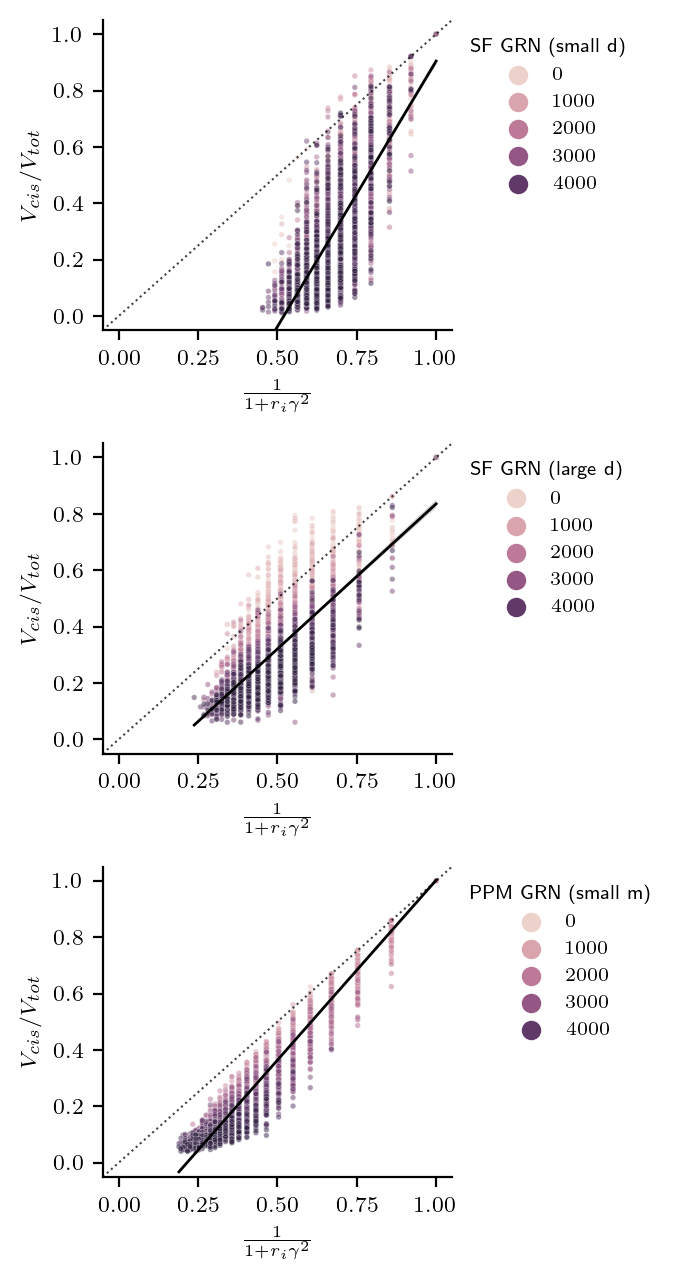

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 6.5), dpi=200)

for i,(G,label) in enumerate(zip([G1,G2,G3], ['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):
    ax = axs[i]

    gd = pd.DataFrame({
        r'$deg_{in}$': (G.A != 0).sum(axis=0),
        r'$\frac{1}{1 + r_{i} \gamma^2}$': 1/(1 + (G.A != 0).sum(axis=0)*(G.A.max()**2)),
        r'$V_{cis}/V_{tot}$': G.cish2,
        'index': np.arange(G.n)
    })

    sns.scatterplot(
        data = gd,
        x = r'$\frac{1}{1 + r_{i} \gamma^2}$',
        y = r'$V_{cis}/V_{tot}$',
        ax = ax,
        hue = 'index',
        alpha = 0.5, 
        s = 4
    )

    sns.regplot(
        data = gd,
        x = r'$\frac{1}{1 + r_{i} \gamma^2}$',
        y = r'$V_{cis}/V_{tot}$',
        ax = ax,
        scatter = 0,
        lowess = 0,
        scatter_kws = dict(alpha=0.3, s=0.5),
        line_kws = dict(linewidth=1, color='k')
    )

    ax.legend(title=label, bbox_to_anchor=(1,1), loc='upper left', frameon=False);

    ax.set_xlim(-0.05, 1.05);
    ax.set_ylim(-0.05, 1.05);
    ax.plot([-0.05, 1.05], [-0.05, 1.05], color='k', linewidth=0.75, alpha=0.75, linestyle='dotted');

sns.despine()
fig.tight_layout();

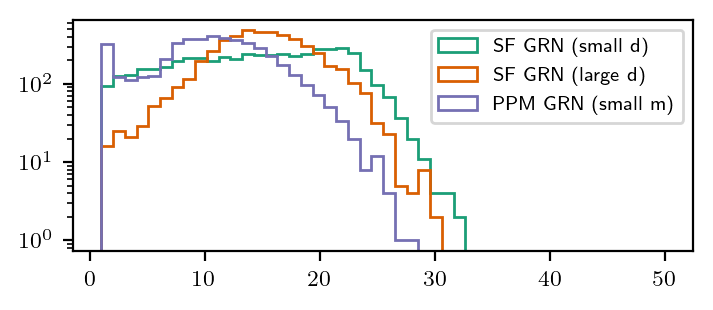

In [20]:
# incoming QTL effects (nominal effect size)
plt.figure(figsize=(4,1.5), dpi=200)

for i,(B,label) in enumerate(zip([B1,B2,B3],['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):
    plt.hist((B > 1e-2).sum(axis=0), label=label, histtype='step', bins=np.linspace(1, 50, 49));
    
plt.semilogy();
plt.legend();
    

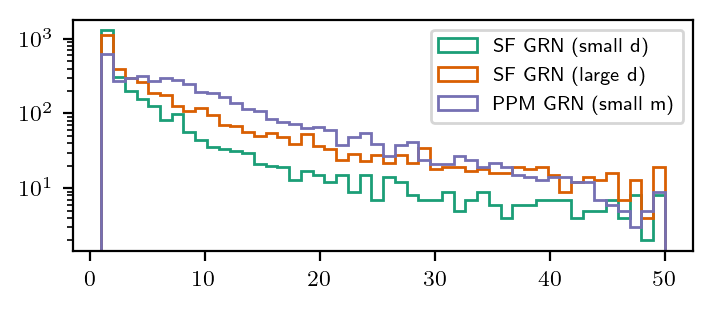

In [21]:
# outgoing QTL effects (nominal effect size)
plt.figure(figsize=(4,1.5), dpi=200)

for i,(B,label) in enumerate(zip([B1,B2,B3],['SF GRN (small d)', 'SF GRN (large d)', 'PPM GRN (small m)'])):
    plt.hist((B > 1e-2).sum(axis=1), label=label, histtype='step', bins=np.linspace(1, 50, 49));

plt.semilogy();
plt.legend();